<a href="https://colab.research.google.com/github/chandan9t8/UnivProjects/blob/main/Anime%20Recommendation%20System/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [ ]:
#First we import our pre-processed data.
anime = pd.read_csv('/content/drive/MyDrive/Data Mining Project/cleaned_anime.csv')

In [ ]:
#We have an important column in the anime df that contains data that we need to convert to numbers: the genre of the media
encode = pd.DataFrame(anime)

#Split the genres string into a list of genres
encode['genre'] = encode['genre'].str.split(', ')

#Get unique genres across all rows
unique_genres = list(set(genre for genres_list in encode['genre'] for genre in genres_list))

#Create a new df with one-hot encoding for each genre
genre_dummies = pd.DataFrame(0, index=encode.index, columns=unique_genres)

#Iterate over rows and update the one-hot encoding df
for i, genres_list in enumerate(encode['genre']):
    genre_dummies.loc[i, genres_list] = 1

#Concatenate the one-hot encoded genres with the original df
encode = pd.concat([encode, genre_dummies], axis=1)

#Drop the original 'Genres' column if needed
data = encode.drop('genre', axis=1)

#Drop any duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

data.head()

,anime_id,name,type,episodes,rating,members,Music,Cars,Harem,Mystery,...,Shounen Ai,Samurai,Military,Historical,Game,School,Shoujo Ai,Yaoi,Fantasy,Comedy
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,28977,Gintama°,TV,51,9.25,114262,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
3,9253,Steins;Gate,TV,24,9.17,673572,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [ ]:
#Grab the features we will cluster on: the average rating of each show and each shows genres
features = data.columns.tolist()
remove = ['anime_id', 'name', 'type', 'episodes','members']
selected_features = [name for name in features if name not in remove]
print(selected_features)

inertia = []
possible_k = list(range(100,3100,100))
k = [1]
possible_k = k + possible_k
print(possible_k)

#Create a loop to iterate through possible values of k for clustering to use with the elbow method
for k in possible_k:
    kmeans = KMeans(k, init='k-means++', n_init=10, random_state=20)
    kmeans.fit(data[selected_features])
    inertia.append(kmeans.inertia_)
    print("Clustering with k = %s/3000:" % k)

['rating', 'Music', 'Cars', 'Harem', 'Mystery', 'Horror', 'Hentai', 'Thriller', 'Action', 'Demons', 'Mecha', 'Drama', 'Kids', 'Martial Arts', 'Yuri', 'Parody', 'Romance', 'Adventure', 'Police', 'Ecchi', 'Josei', 'Seinen', 'Psychological', 'Space', 'Shounen', 'Shoujo', 'Sci-Fi', 'Slice of Life', 'Dementia', 'Super Power', 'Vampire', 'Supernatural', 'Sports', 'Magic', 'Shounen Ai', 'Samurai', 'Military', 'Historical', 'Game', 'School', 'Shoujo Ai', 'Yaoi', 'Fantasy', 'Comedy']
[1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]
Clustering with k = 1/3000:
Clustering with k = 100/3000:
Clustering with k = 200/3000:
Clustering with k = 300/3000:
Clustering with k = 400/3000:
Clustering with k = 500/3000:
Clustering with k = 600/3000:
Clustering with k = 700/3000:
Clustering with k = 800/3000:
Clustering with k = 900/3000:
Clustering with k = 1000/3000:
Clustering with 

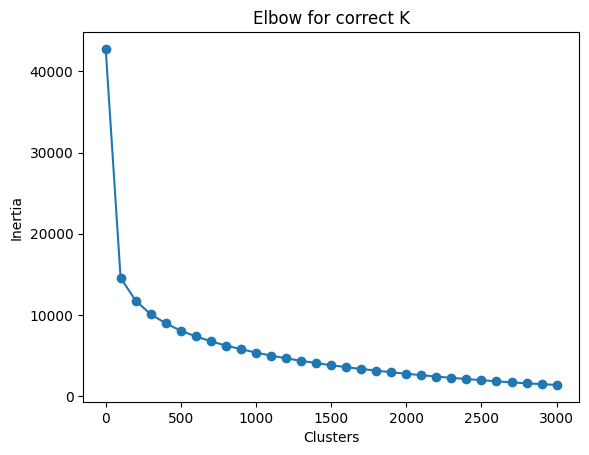

In [ ]:
#Plot the inertia per different values of k to pick the best one via elbow method
plt.plot(possible_k, inertia, marker='o')
plt.xlabel("Clusters")
plt.ylabel('Inertia')
plt.title("Elbow for correct K")
plt.show()

In [ ]:
kmeans = KMeans(500, init='k-means++', n_init=10, random_state=20)
data['Cluster'] = kmeans.fit_predict(data[selected_features])

In [ ]:
#Recommend show based on selected show: Bleach is 269, Naruto is 20, One Piece is 21
show_id = 21

#Identify the cluster of the given anime
anime_cluster = data.loc[data['anime_id'] == show_id, 'Cluster'].values[0]

#Filter the DataFrame to include only shows in the same cluster
cluster_data = data[data['Cluster'] == anime_cluster]
cluster_data = cluster_data.reset_index()

#Grab the index of the show within the local cluster
cluster_index = cluster_data[cluster_data['anime_id'] == show_id].index[0]

#Calculate pairwise distances using Euclidean distance
distances = pairwise_distances(cluster_data[selected_features], cluster_data[selected_features], metric='euclidean')

#Find the indices of the 10 closest shows
closest_indices = distances[cluster_index].argsort()[1:11]

#Display the 10 "closest" shows
closest_shows = data.loc[data['Cluster'] == anime_cluster].iloc[closest_indices]['name']
print("The recommended shows similar to anime_id %s (%s) are as follows: \n%s" % (show_id, data.loc[data['anime_id'] == show_id]['name'].iloc[0], closest_shows))
#print(closest_shows)

The recommended shows similar to anime_id 21 (One Piece) are as follows: 
231     One Piece: Episode of Merry - Mou Hitori no Na...
241     One Piece: Episode of Nami - Koukaishi no Nami...
896     One Piece: Episode of Sabo - 3 Kyoudai no Kizu...
143                          One Piece Film: Strong World
163                                     One Piece Film: Z
212                                  One Piece Film: Gold
960                              One Piece: Heart of Gold
2472                                     Digimon Frontier
133                            Tsubasa: Tokyo Revelations
200                                   Fullmetal Alchemist
Name: name, dtype: object
